# 🔬Stable Diffusion 조금 들어가보기

latent diffusion 모델은 diffusion process 를 pixel 공간이 아닌 latent 공간에서 수행하여 memory , complexity 를 낮춘데 의미가 있음

예를 들어 3 채널의 512 이미지는 [3, 512, 512] 의 pixel 공간으로 표현되나 latent 공간에서는 이를 [3, 64, 64] 로 표현 할 수 있음

latent diffusion 모델은 pixel 을 예측하는 것이 아니라 latent 를 예측하는 것임 (latent 를 가지고 decoding 과정을 수행해 pixel 로 만드는 것임)

이러한 latent diffusion 모델은 `VAE (Variation Auto Encoder)`, `U-Net` , `Text Encoder` 로 구성됨

`VAE (Variation Auto Encoder)` 

- encoder 와 decoder 로 구성되어 pixel 을 latent 로 인코딩하거나 그 반대로 디코딩하는 역할 (latent ↔ pixel)

  - encoder : 학습 과정에서 이미지를 latent 표현으로 변환. 이것을 이용하여 foward diffusion process 가 수행

  - decoder : 추론 과정에서 noise 에서 역변환된 latent 를 이미지로 변환

- SD 모델 사용시에는 VAE 의 decoder 만 활용되다는 의미

`U-Net`

- ★ 노이즈의 잔차(noise residual) 을 예측하는 역할. 

  - ★ 이 noise residual 은 scheduler 에 의해 활용되어 그 만큼의 노이즈가 제거된 image 가 되는 것

    - DDIM, DDPM, K-LMS 등 다양한 scheduling 알고리즘이 존재함 (베타 스케쥴링일 듯함)

- encoder 와 decoder 로 구성

  - high resolution image → low resultion iamge 의 변환은 encoder 가 수행

  - decoder 는 위와 반대 방향인데 noise 가 좀 더 줄어는 형태의 high resolution image 임


`Text Encoder`

- 프롬프트를 `U-Net` 이 이해할 수 있는 형태로 임베딩하는 역할

- SD 는 CLIPTextModel 을 그대로 사용함


추론 과정에서는 다음과 같은 작업들이 내부적으로 일어나는 것임

![image.png](/assets/stable_diffusion.png)



References
- https://huggingface.co/blog/stable_diffusion
- https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0



In [ ]:
!pip install diffusers --upgrade
!pip install invisible_watermark transformers accelerate safetensors

In [3]:
import torch

generator = torch.Generator("cuda").manual_seed(0)

n_steps = 100

high_noise_frac = 0.5

prompt = "A real picture of an astronaut riding a green horse"

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

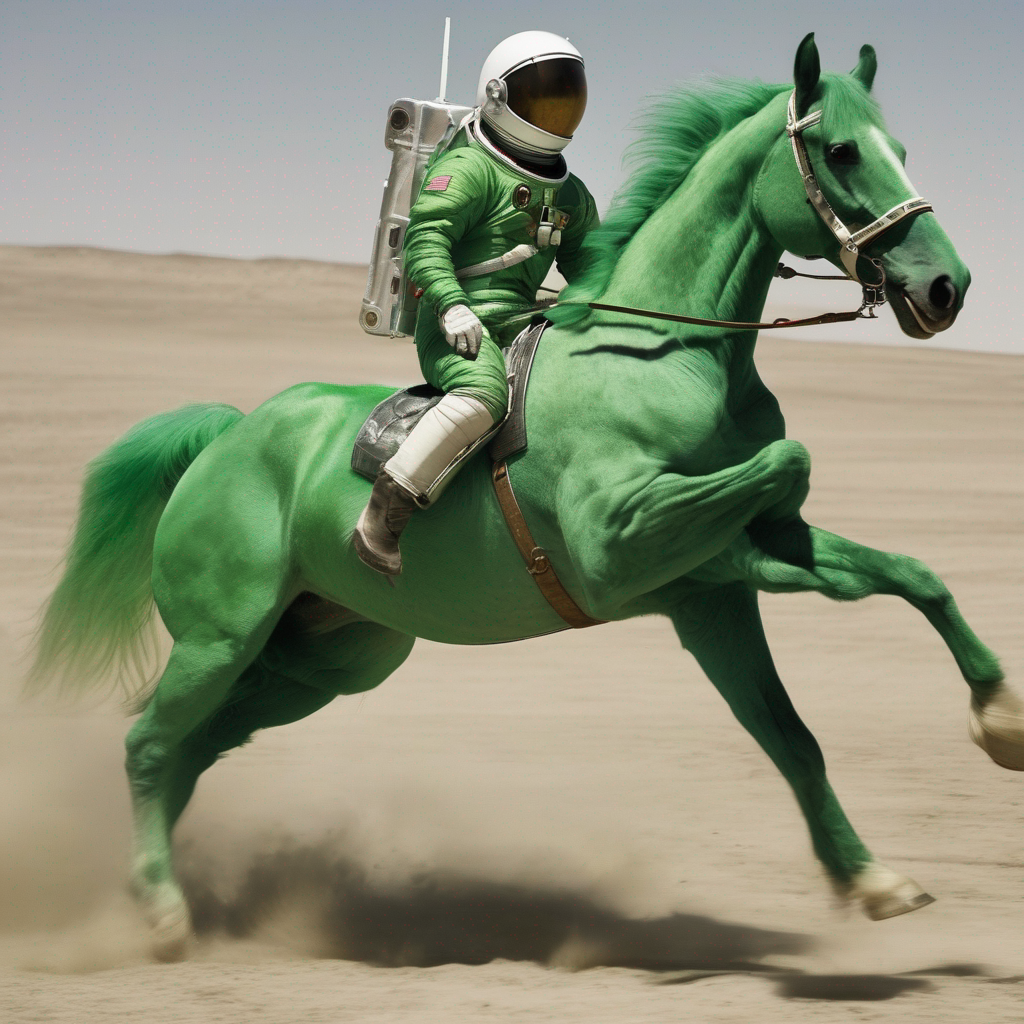

In [6]:
##############################################################################################
# Base Model 만 사용하기
##############################################################################################

from diffusers import DiffusionPipeline
import torch

base = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", 
                                         torch_dtype=torch.float16, 
                                         use_safetensors=True,
                                         variant="fp16")
base.to("cuda")

image = base(prompt=prompt, 
              num_inferences=n_steps,
              # denoising_end=high_noise_frac,
              generator = generator).images[0]

image

## Base 모델과 Refiner 연결

- Refiner 는 Base 모델이 생성한 이미지를 세밀하게 처리하는 것이 목적이고 다음의 작업을 수행
  
  - 노이즈를 유지거나 디테일 개선을 위한 추가 노이즈를 생성

  - 추가 노이즈를 적용한다는 것은 이미지에 의도적으로 불확실성을 증가시켜 모델이 이를 해석하도록 하는 과정에서 미세조정 

- Refiner 모델이 Base 모델의 텍스트 인코딩과 VAE 를 사용함으로서 Base 모델이 생성한 이미지를 더 깊게 이해할 수 있도록 함

In [2]:
from diffusers import DiffusionPipeline
import torch

base = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                        torch_dtype=torch.float16,
                                        variant='fp16',
                                        use_safetensors=True)
base.to('cuda')
refiner = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
                                            text_encoder_2 = base.text_encoder_2,   # base 모델의 text_encoder 를 사용
                                            vae=base.vae,                           # base 모델의 vae 를 사용
                                            torch_dtype=torch.float16,  
                                            use_safetensors=True,
                                            variant='fp16')
refiner.to('cuda')

# torch.compile(pipe.unet)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.26.2",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

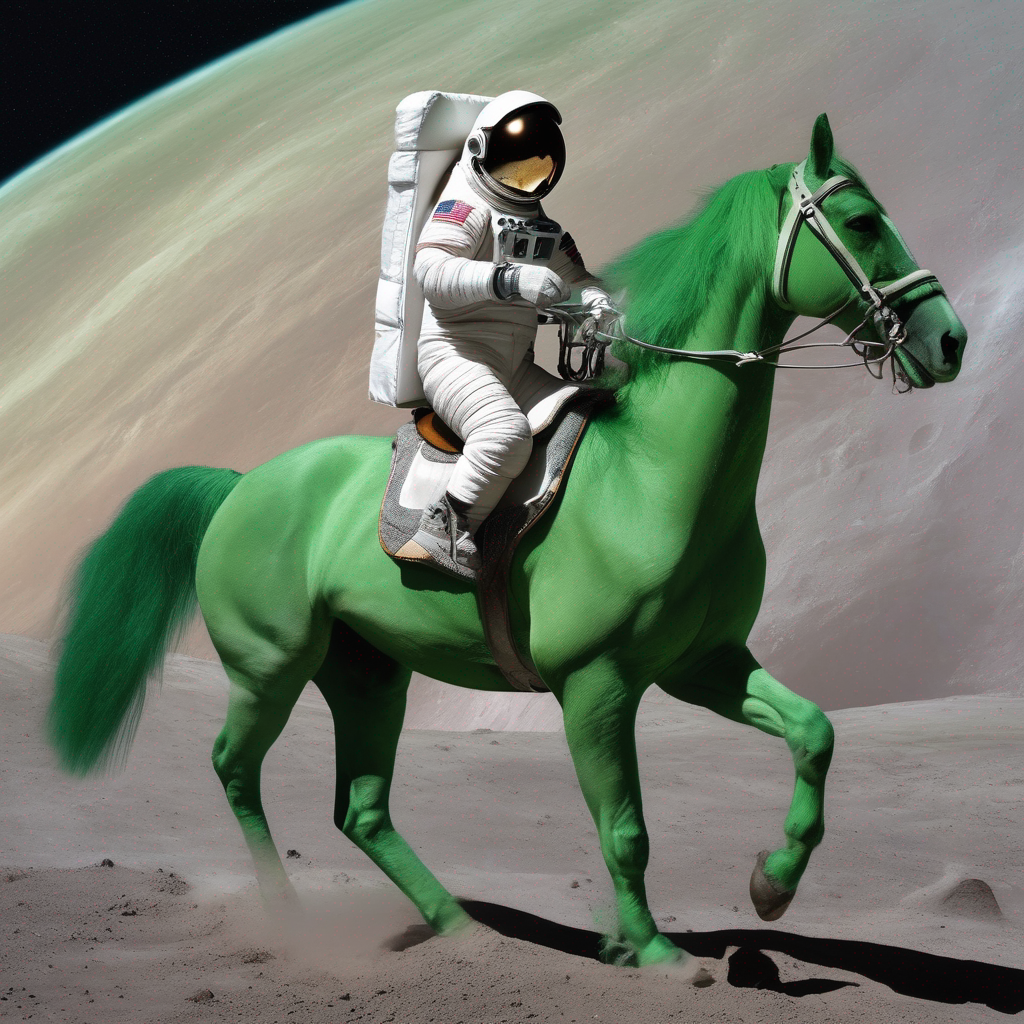

In [4]:

image = base(prompt=prompt,
                num_inferences=n_steps,
                denoising_end=high_noise_frac,  # noise 제거가 종료되는 시점 정의
                generator = generator,
                output_type="latent"            # refiner 에 전달할 목적으로 latent 공간에서 이미지 생성 
            ).images

image = refiner(prompt=prompt,
                num_inferences=n_steps,
                denoising_start=high_noise_frac,# noise 제거가 시작되는 시점 정의
                generator = generator,
                image=image).images[0]

image


In [ ]:
import gc

del base
del refiner
del image

gc.collect()

torch.cuda.empty_cache()


## Stable Diffusion 조금 살펴본 것 가지고 Custom Pipeline 구성해보기

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import LMSDiscreteScheduler

vae = AutoencoderKL.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='vae')

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

unet = UNet2DConditionModel.from_pretrained('CompVis/stable-diffusion-v1-4', subfolder='unet')

torch_device = 'cuda'
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

scheduler = LMSDiscreteScheduler(beta_start=0.0085, 
                                 beta_end=0.012, 
                                 beta_schedule='scaled_linear', 
                                 num_train_timesteps=1000)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [5]:
import torch

prompt = ['a photograph of an astronaut riding a horse']

height = 512                # default height of SD
width = 512                 # default widht of SD

num_inference_steps = 100   # number of denoising steps

guidance_scale = 7.5        # scale for classifier-free guidance

generator = torch.manual_seed(0)

batch_size = len(prompt)


text_input = tokenizer(prompt, 
                       padding='max_length',                    # max length 에 맞춰서 남는 공간에 패딩 추가
                       max_length=tokenizer.model_max_length,   # tokenized 형태에서의 sequence 최대 길이 
                       truncation=True,                         # sequence 가 최대 길이를 넘으면 잘라버림
                       return_tensors='pt')                     # pytorch 의 tesnor 형태
text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

text_input , text_embeddings

({'input_ids': tensor([[49406,   320,  8853,   539,   550, 18376,  6765,   320,  4558, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
          49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]])},
 tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],


In [8]:
######################################################################################################
# Classifier Free Guidance 를 위해서는 두 개의 foward pass 필요함
# -  하나는 conditioned  , 또 다른 하나는 uncoditional inpput
######################################################################################################
max_length = text_input.input_ids.shape[-1]

uncond_input = tokenizer(
    [""] * batch_size, padding = 'max_length', max_length = max_length, return_tensors = 'pt'
)
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [10]:
uncond_embeddings

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
         [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
         ...,
         [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
         [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
         [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [11]:
text_embeddings.shape, uncond_embeddings.shape

(torch.Size([1, 77, 768]), torch.Size([1, 77, 768]))

In [13]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
text_embeddings, text_embeddings.shape

(tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
          [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
          ...,
          [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
          [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
          [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],
 
         [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [-0.3711, -1.4497, -0.3401,  ...,  0.9489,  0.1867, -1.1034],
          [-0.5107, -1.4629, -0.2926,  ...,  1.0419,  0.0701, -1.0284],
          ...,
          [ 0.5006, -0.9552, -0.6610,  ...,  1.6013, -1.0622, -0.2191],
          [ 0.4988, -0.9451, -0.6656,  ...,  1.6467, -1.0858, -0.2088],
          [ 0.4923, -0.8124, -0.4912,  ...,  1.6108, -1.0174, -0.2484]],
 
         [[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
          [ 0.0290, -1.3258,

In [15]:
######################################################################################################
# Initial Random Noise 생성
######################################################################################################
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8 , width // 8),
    generator = generator
)
latents = latents.to(torch_device)
latents, latents.shape 

/tmp/ipykernel_644/618463521.py:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8 , width // 8),


(tensor([[[[-0.5518,  1.5398,  1.0036,  ...,  0.6175,  0.1804,  0.8046],
           [ 0.9609,  1.5425, -1.2702,  ..., -0.7435, -0.4808,  0.6858],
           [-0.6004, -0.1705,  1.5333,  ...,  0.6941,  1.3814,  1.1507],
           ...,
           [ 0.1905, -0.0357,  0.8476,  ..., -0.8909,  1.2038,  0.8128],
           [-0.4964, -0.2778, -0.2999,  ...,  0.9517, -1.1224, -0.5153],
           [-0.4429, -0.2158, -1.4242,  ..., -0.7115,  2.1101, -0.7824]],
 
          [[-1.6218, -0.5825,  0.8071,  ...,  0.2913,  0.6123, -1.1252],
           [ 0.3186, -0.7650, -1.4765,  ...,  1.9693,  0.5988,  0.6534],
           [ 1.8282, -0.3731,  0.8601,  ...,  1.1382, -0.4471, -0.8608],
           ...,
           [ 1.3572,  0.3041, -0.1303,  ...,  0.6212,  1.2829, -0.5572],
           [-0.8838, -2.1552, -0.8310,  ..., -0.5427,  0.0567, -0.7115],
           [-0.7083, -0.3913,  1.4362,  ..., -0.5943, -0.9046,  1.0126]],
 
          [[ 0.3909,  0.7654, -0.2531,  ..., -0.3234,  0.6719,  0.8665],
           [ 

In [17]:
######################################################################################################
# 스케쥴러 스텝 설정 및 초기 latents 가중치(noise sigma) 설정
# - noise sigman 는 K-LMS 알고리즘 특화 설정
######################################################################################################
scheduler.set_timesteps(num_inference_steps)

latents = latents * scheduler.init_noise_sigma

scheduler, latents

(LMSDiscreteScheduler {
   "_class_name": "LMSDiscreteScheduler",
   "_diffusers_version": "0.26.2",
   "beta_end": 0.012,
   "beta_schedule": "scaled_linear",
   "beta_start": 0.0085,
   "num_train_timesteps": 1000,
   "prediction_type": "epsilon",
   "steps_offset": 0,
   "timestep_spacing": "linspace",
   "trained_betas": null,
   "use_karras_sigmas": false
 },
 tensor([[[[-15650.2568,  43669.4531,  28461.2656,  ...,  17511.8711,
              5115.9941,  22818.8086],
           [ 27250.5898,  43744.7227, -36024.1289,  ..., -21084.8926,
            -13635.7109,  19449.7988],
           [-17026.5684,  -4835.0840,  43485.5469,  ...,  19685.3340,
             39176.5039,  32634.7129],
           ...,
           [  5401.7456,  -1013.1196,  24037.5371,  ..., -25264.9355,
             34138.8281,  23052.3340],
           [-14078.0225,  -7878.4253,  -8504.3740,  ...,  26991.8574,
            -31832.0527, -14614.0605],
           [-12559.7168,  -6120.7715, -40390.9453,  ..., -20179.7773,
  

In [19]:
######################################################################################################
# Denoising Loop
# - 설정한 단계 수만큼 CFG 알고리즘에 맞추어 노이즈가 제거된 latent 를 만들어 냄
######################################################################################################
from tqdm.auto import tqdm

for t in tqdm(scheduler.timesteps):
    # cfg 를 위해 별도로 foward 를 진행하게 하지 않고 한번에 수행하기 위해 2개 latent 를 덧붙임
    # latent_model_input = torch.cat([latents] * 2)
    latent_model_input = torch.cat([latents] * 2)
    # latent_model_input = scheduler.scale_model_input(latent_model_input, timestep = t)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    
    # 임베딩된 prompt 와 함께 latent_model_input (노이즈) 를 단계(t)에 맞게 전달하여 residual 을 예측함 
    # with torch.no_grad():
    #     noise_pred = unet(latent_model_input, 
    #                       t, 
    #                       encoder_hidden_states = text_embeddings).sample
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    
    # 덧붙였던 tensor 로 예측된 residual 을  다시 분리하여 하나는 unconditional, 하나는 conditional 로 사용
    # noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    # unconditional 과 conditional 각 경우의 resiual 의 차이에 guidance scale 만큼을 반영하여
    # 이것을 unconditional 인 경우의 resiaul 에 더해서 최종 residual 로 함
    # noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    
    # scheduler 에게 이번 단계의 noise residual 예측값을 전달해서 이를 차감한 이미지의 latent 를 얻고 이것으로 latents 를 설정
    # → 다음 t 에서는 이 latent 를 가지고 반복함
    # latents = scheduler.step(noise_pred, t , latents).prev.sample
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: shape '[3, -1, 8, 40]' is invalid for input of size 2621440

In [ ]:
######################################################################################################
# Decode 'Latent' into 'Image'
######################################################################################################

latents = 1 / 0.18215 * latents

with torch.no_grad():
    image  = vae.decode(latents).sample

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)

image = image.detach().cpu().permutate(0, 2,3,1).numpy()

images = (image * 255).round().astype('uint8')

pil_images = [Image.fromarray(image) for image in images]

pil_images[0]